### Figure generation notebook for Merlin analysis

JL 2021-12-02 to do:
- generate low res mosaic directly from data instead of needing a saved file
- replace RefineCellDatabases pull with MERlin backend instead of loading file directly

In [1]:
!pip install matplotlib-scalebar
!pip install fs

In [2]:
import fs
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np
import seaborn as sns
from skimage.io import imread
import tifffile
from fs import open_fs
import h5py
import string
from merlin.core import dataset
from skimage.measure import block_reduce
import scanpy as sc

mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Colors in this style
# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')

plt.ion()

In [3]:
# Load raw MERFISH results
# Define the path of the analyzed data

data_path = '/mnt/ibm_lg/spatial-seq/MERlin_Analysis'

# Define the experiment

experiment_name = 'MsKidney_CellBoundary_VZG116_111921'

d_set = dataset.MERFISHDataSet(experiment_name)
fs = open_fs(os.path.join(data_path, experiment_name))

print('Dataset loaded.')

decodedTranscripts = pd.read_csv(os.path.join(data_path, experiment_name, 'ExportBarcodes', 'region_0',
                                             'barcodes.csv'))

print('Decoded barcodes loaded.')

cell_metadata = pd.read_csv(os.path.join(
    data_path, experiment_name, 'ExportCellMetadata/region_0/feature_metadata.csv'), index_col=0)

print('Cell metadata loaded')



Dataset loaded.
Decoded barcodes loaded.
Cell metadata loaded


In [4]:
# Load alignment parameters to transform between local/global coordinates

globalAlignment = d_set.load_analysis_task('CorrelationGlobalAlignment')

In [5]:
# Load DAPI mosaic
zInd = 3
z_stack = ['z0','z1','z2','z3','z4','z5','z6']
dscale = 20 # Downsampling factor

dapi_mosaic = tifffile.TiffFile(os.path.join(
    data_path, experiment_name, "BlendMosaic", "region_0" , 'mosaic_DAPI_' + z_stack[zInd] + '.tif')).asarray()

# Downsample DAPI mosaic using block reduce for low-res plot
dapi_mosaic_lowres = block_reduce(dapi_mosaic, block_size=(dscale, dscale), func=np.mean)

print('DAPI mosaic loaded.')

DAPI mosaic loaded.


### Panel A: Original mosaic for the whole dataset

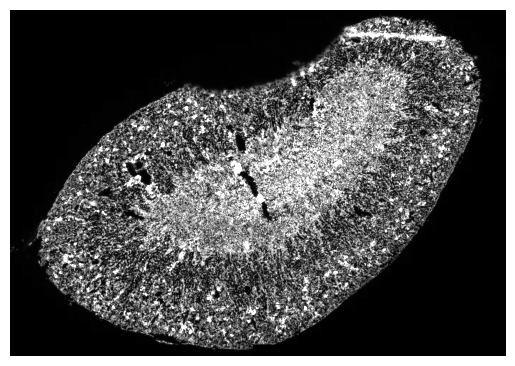

In [6]:
plt.axis('off')
plt.imshow(dapi_mosaic_lowres, cmap='gray', vmax=20000)
plt.show()

### Panel B: Zoomed in raw image with example channels and decoded transcripts/segmentation boundaries

/tmp/ipykernel_2693520/3215633871.py:19: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  cell_boundaries = h5py.File(current_file)


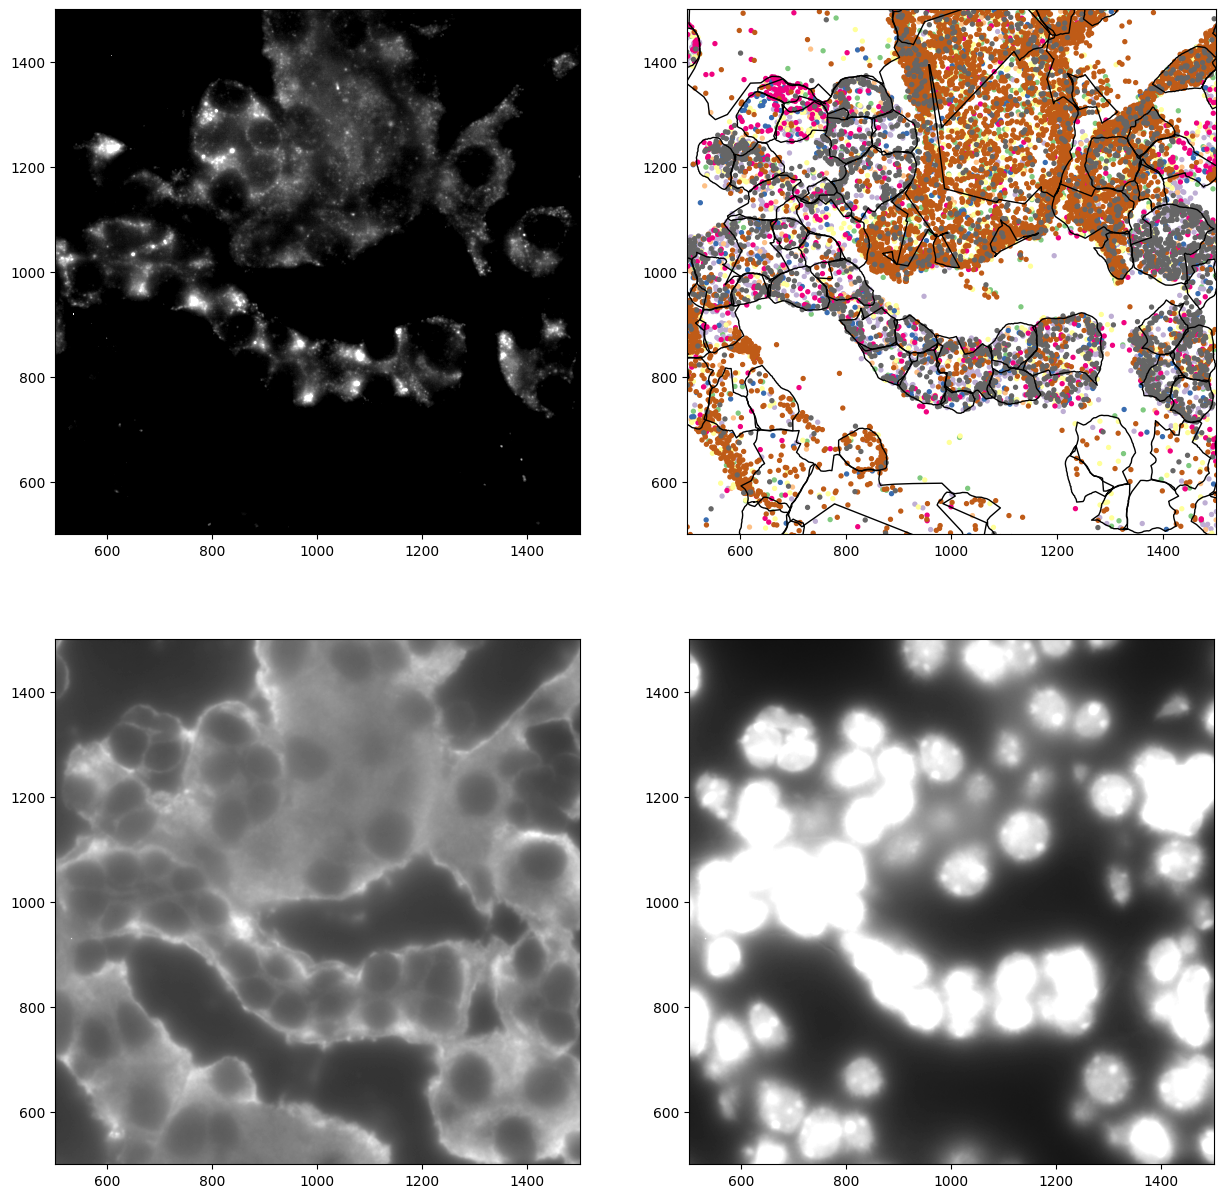

In [7]:
fov = 30
zInd = 3
minX = 500
maxX = 1500
minY = 500
maxY = 1500
ch = [0,1,24,28] #Bit 1, Bit 2, CellBound3, and DAPI respectively

# Matrix to transform from global micron coordinates to local fov pixel coordinates
transformation_matrix_2 = np.linalg.inv(globalAlignment.fov_to_global_transform(fov))
size_of_one_pixel = 1 / transformation_matrix_2[0,0]

# Get the warped raw images
warp = d_set.load_analysis_task('FiducialCorrelationWarp')

# Get the boundary segmentation coordinates
current_file = os.path.join(data_path, experiment_name, 
                            'RefineCellDatabases', 'features', 'feature_data_%i.hdf5' % fov)
cell_boundaries = h5py.File(current_file)
current_cells = []
for i in cell_metadata[cell_metadata['fov'] == fov].index:
    if i in cell_boundaries['featuredata'] and 'p_0' in cell_boundaries['featuredata'][i]['zIndex_%i' % zInd]:
        temp = np.array(cell_boundaries['featuredata'][i]['zIndex_%i' % zInd]['p_0']['coordinates'][0])
        boundary_polygon = np.ones((temp.shape[0], temp.shape[1]+1))
        boundary_polygon[:, :-1] = temp
        transformed_boundary = np.matmul(transformation_matrix_2, np.transpose(boundary_polygon))[:-1]
        current_cells.append(transformed_boundary)

fig, ax = plt.subplots(2,2, figsize=(15,15))

# Bit 1
warped_im = warp.get_aligned_image(fov, ch[0], zInd)
ax[0,0].imshow(warped_im, cmap='gray', vmin=3000, vmax=7000, origin='lower')
ax[0,0].set_xlim(minX, maxX)
ax[0,0].set_ylim(minY, maxY)
#ax[0,0].axis("off")

# Positions of decoded transcripts + segmented boundaries
transcripts_fov = decodedTranscripts[decodedTranscripts['fov'] == fov]
ax[0,1].scatter(transcripts_fov['x'], transcripts_fov['y'], 
                c=transcripts_fov['barcode_id'], cmap='Accent', s=8)
#ax[0,1].imshow(warped_im, cmap='bone', vmin=3000, vmax=6000, origin='lower')
for tb in current_cells:
    ax[0,1].plot(tb[0], tb[1], 'k', linestyle='-', linewidth=1)
    
ax[0,1].set_xlim(minX, maxX)
ax[0,1].set_ylim(minY, maxY)

# CellBound3
warped_im = warp.get_aligned_image(fov, ch[2], zInd)
ax[1,0].imshow(warped_im, cmap='gray', vmin=0, vmax=30000, origin='lower')

ax[1,0].set_xlim(minX, maxX)
ax[1,0].set_ylim(minY, maxY)
#ax[1,0].axis("off")

# DAPI
warped_im = warp.get_aligned_image(fov, ch[3], zInd)
ax[1,1].imshow(warped_im, cmap='gray', vmin=0, vmax=20000, origin='lower')

ax[1,1].set_xlim(minX, maxX)
ax[1,1].set_ylim(minY, maxY)
#ax[1,1].axis("off")

plt.show()

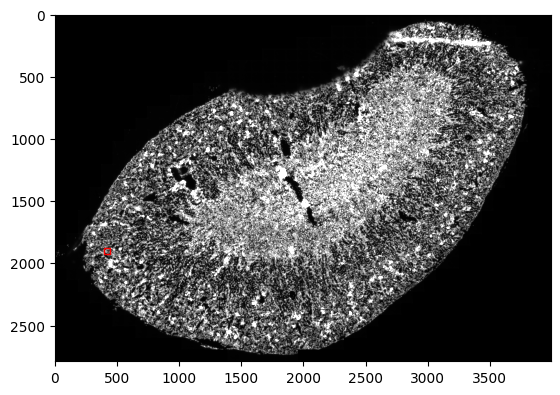

In [8]:
globMinX, globMinY = globalAlignment.fov_coordinates_to_global(fov, (minX, minY))
globMaxX, globMaxY = globalAlignment.fov_coordinates_to_global(fov, (maxX, maxY))

globMinX = globMinX / (dscale * size_of_one_pixel)
globMaxX = globMaxX / (dscale * size_of_one_pixel)
globMinY = globMinY / (dscale * size_of_one_pixel)
globMaxY = globMaxY / (dscale * size_of_one_pixel)

# Create rectangle for zoomed in snippet
rect = mpatches.Rectangle((globMinX, globMinY), globMaxX - globMinX, 
                          globMaxY - globMinY, linewidth=1, edgecolor='r', facecolor='none')

fig, ax = plt.subplots()
ax.imshow(dapi_mosaic_lowres, cmap='gray', vmax=20000)
ax.add_patch(rect)
plt.show()

### Panel F: Boundary image (not using right now)

In [9]:
# with fs.open(os.path.join('RefineCellDatabases', 'features', 'feature_data_%i.hdf5' % fov), 'rb') as current_file:
#     cell_boundaries = h5py.File(current_file)
#     current_cells = []
#     for i in cell_metadata[cell_metadata['fov'] == fov].index:
#         if i in cell_boundaries['featuredata'] and 'p_0' in cell_boundaries['featuredata'][i]['zIndex_%i' % z_index]:
#             temp = np.array(cell_boundaries['featuredata'][i]['zIndex_%i' % z_index]['p_0']['coordinates'][0])
#             boundary_polygon = np.ones((temp.shape[0], temp.shape[1]+1))
#             boundary_polygon[:, :-1] = temp
#             transformed_boundary = np.matmul(transformation_matrix, np.transpose(boundary_polygon))[:-1]
#             current_cells.append(transformed_boundary)
# min_coord = np.min([np.min(x, axis=1) for x in current_cells], axis=0).astype(int)
# max_coord = np.max([np.max(x, axis=1) for x in current_cells], axis=0).astype(int)       

# detected_transcripts = pd.read_csv(os.path.join(
#     data_path, experiment_name, 'ExportBarcodes/region_0/barcodes.csv'), index_col=0)
# active_transcripts = detected_transcripts[detected_transcripts['fov'] == fov].copy()
# temp = active_transcripts[['global_x', 'global_y']].values
# transcript_positions = np.ones((temp.shape[0], temp.shape[1]+1))
# transcript_positions[:, :-1] = temp
# transformed_positions = np.matmul(transformation_matrix, np.transpose(transcript_positions))[:-1]
# active_transcripts.loc[:, 'local_x'] = transformed_positions[0, :]
# active_transcripts.loc[:,'local_y'] = transformed_positions[1, :]

# plt.figure(figsize=(15,15))
# plt.imshow(dapi_mosaic[min_coord[1]:max_coord[1], min_coord[0]:max_coord[0]], cmap=plt.cm.gray)

# for tb in current_cells:
#     plt.plot(tb[0]-min_coord[0], tb[1] - min_coord[1], 'g', linestyle=':')

# points = [active_transcripts['local_y'] - min_coord[1], active_transcripts['local_x'] - min_coord[0]]
# plt.scatter(
#     points[1],
#     points[0],color='r',s=0.1, alpha=0.5)

### Plot combined figure

13321 transcripts in Panel E.


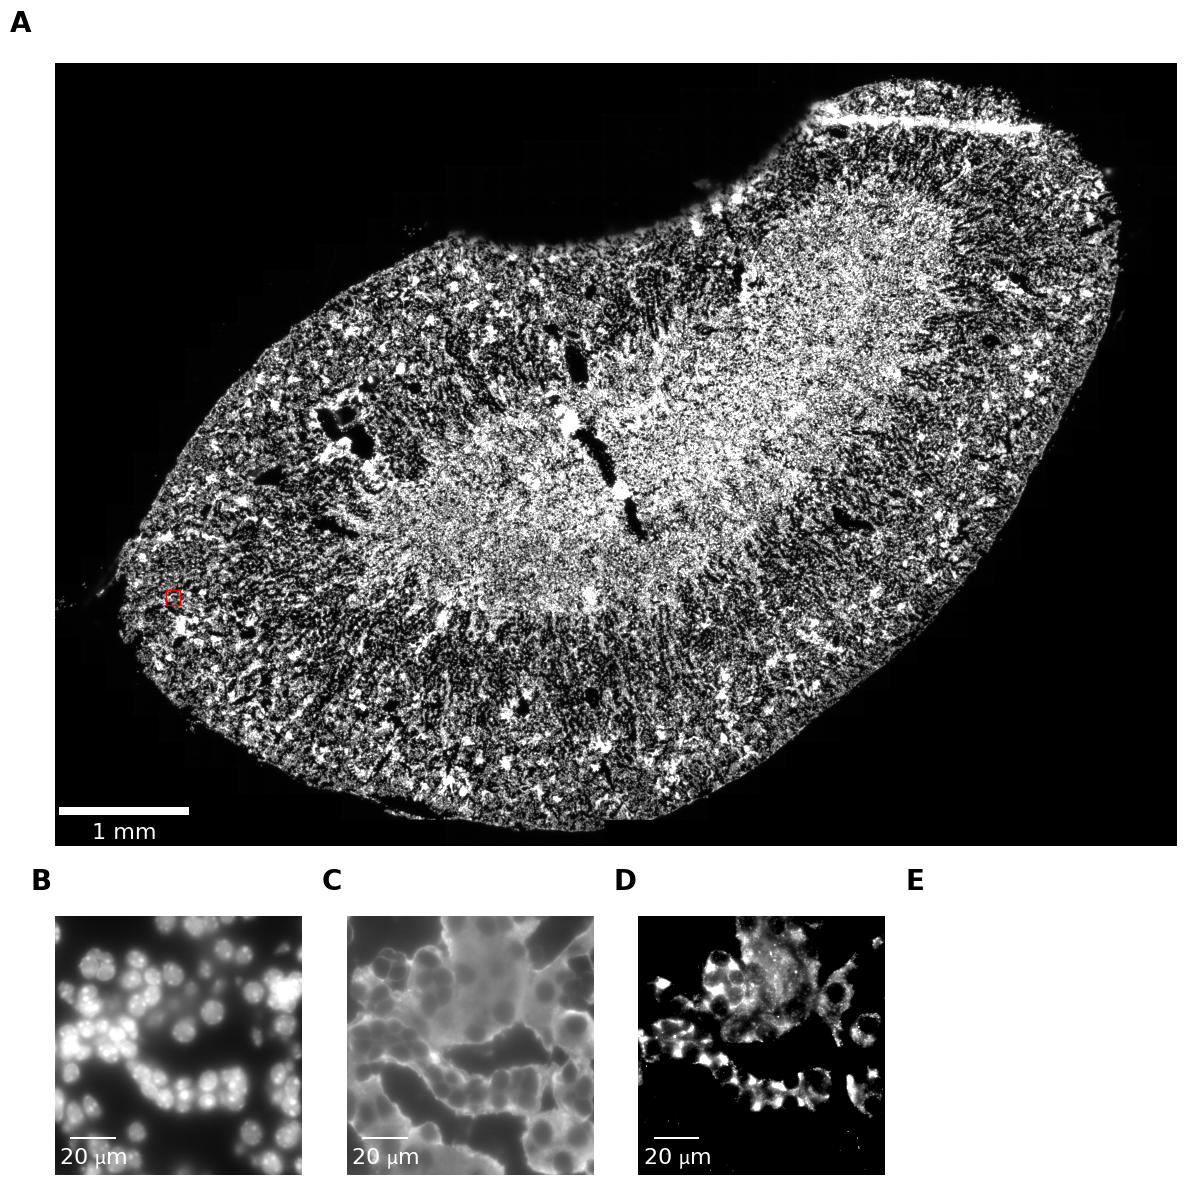

In [13]:
# Plot the whole figure
set_plotting_style()
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(12, 12))
gs = ax[0,0].get_gridspec() #Get gridspecs

# remove the underlying axes for Panel A
for i in [0,1,2]:
    for j in [0,1,2,3]:
        ax[i,j].remove()

axbig = fig.add_subplot(gs[0:3, 0:4])

# Panel A: low-res mosaic
axbig.axis("off")
axbig.imshow(dapi_mosaic_lowres, cmap="gray", vmax=20000, aspect='equal')
scalebar = ScaleBar(size_of_one_pixel*dscale/1000, "mm", color='w', box_color='k', box_alpha=0, location='lower left', 
                   font_properties={'size':16})
axbig.add_artist(scalebar)
rect = mpatches.Rectangle((globMinX, globMinY), globMaxX - globMinX, 
                          globMaxY - globMinY, linewidth=1, edgecolor='r', facecolor='none')
axbig.add_patch(rect)

# Panel B: DAPI
axis = ax[3,0]
axis.axis("off")
warped_im = warp.get_aligned_image(fov, ch[3], zInd)
axis.imshow(warped_im, cmap='gray', vmin=0, vmax=30000, origin='lower', aspect='auto')

axis.set_xlim(minX, maxX)
axis.set_ylim(minY, maxY)
scalebar = ScaleBar(size_of_one_pixel, "um", color='w', box_color='w', box_alpha=0, location='lower left', 
                   font_properties={'size':16})
axis.add_artist(scalebar)

# Panel C: cell boundary stain
axis = ax[3,1]
axis.axis("off")
warped_im = warp.get_aligned_image(fov, ch[2], zInd)
axis.imshow(warped_im, cmap='gray', vmin=0, vmax=30000, origin='lower', aspect='auto')

axis.set_xlim(minX, maxX)
axis.set_ylim(minY, maxY)
scalebar = ScaleBar(size_of_one_pixel, "um", color='w', box_color='w', box_alpha=0, location='lower left', 
                   font_properties={'size':16})
axis.add_artist(scalebar)


# Panel D: Bit 1
axis = ax[3,2]
axis.axis("off")
warped_im = warp.get_aligned_image(fov, ch[0], zInd)
axis.imshow(warped_im, cmap='gray', vmin=3000, vmax=5000, origin='lower', aspect='auto')
axis.set_xlim(minX, maxX)
axis.set_ylim(minY, maxY)
scalebar = ScaleBar(size_of_one_pixel, "um", color='w', box_color='w', box_alpha=0, location='lower left', 
                   font_properties={'size':16})
axis.add_artist(scalebar)

                  
# Panel E: decoded transcripts + segmented boundaries
# Leave this blank since we will replace with a png
axis = ax[3,3]
axis.axis("off")
# axis.scatter(transcripts_fov['x'], transcripts_fov['y'], 
#                 c=transcripts_fov['barcode_id'], cmap='Accent', s=2)
# for tb in current_cells:
#     axis.plot(tb[0], tb[1], 'k', linestyle='-', linewidth=0.8)
    
# axis.set_xlim(minX, maxX)
# axis.set_ylim(minY, maxY)
# scalebar = ScaleBar(size_of_one_pixel, "um", color='k', box_color='k', box_alpha=0, location='lower left', 
#                    font_properties={'size':16})
#ax[1, 3].add_artist(scalebar)

# How many transcripts are shown in Panel E?
N_transcripts = np.sum(np.logical_and(np.logical_and(transcripts_fov['x'] > minX, transcripts_fov['x'] < maxX),
                   np.logical_and(transcripts_fov['y'] > minY, transcripts_fov['y'] < maxY)))
print(str(N_transcripts) + ' transcripts in Panel E.')


# Label subpanels
axes = [axbig, ax[3,0], ax[3,1], ax[3,2], ax[3,3]]
for n, ax in enumerate(axes):
    if n == 0:
        ax.text(-0.04, 1.04, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')
    else:
        ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
                size=20, weight='bold')
fig.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
fig.tight_layout()

plt.show()

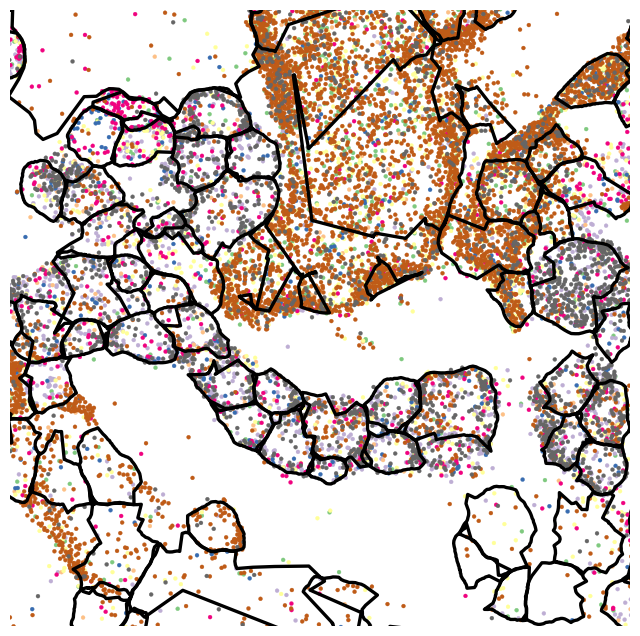

In [14]:
# Just Panel E
# Panel E: decoded transcripts + segmented boundaries
subfig, ax = plt.subplots(figsize=(8,8))
axis = ax
axis.axis("off")
axis.scatter(transcripts_fov['x'], transcripts_fov['y'], 
                c=transcripts_fov['barcode_id'], cmap='Accent', s=8)
for tb in current_cells:
    axis.plot(tb[0], tb[1], 'k', linestyle='-', linewidth=2.4)
    
axis.set_xlim(minX, maxX)
axis.set_ylim(minY, maxY)
scalebar = ScaleBar(size_of_one_pixel, "um", color='k', box_color='k', box_alpha=0, location='lower left', 
                   font_properties={'size':16})

In [15]:
# Export figures
fig.savefig('../../figures/Fig2_merlin_image_analysis_example.svg', transparent=True)
fig.savefig('../../figures/Fig2_merlin_image_analysis_example.png', transparent=True)

subfig.savefig('../../figures/Fig2_merlin_image_analysis_example_PanelE.png', transparent=True)

print('Figures saved.')

Figures saved.
